<div style="line-height:1.2;">

<h1 style="color:#BF66F2; margin-bottom: 0.3em;">Feedforward Neural Networks in PyTorch 1</h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1em;">Example of a NN composed by Fully Connected Layers. Focus on graph visualization.</h4>

<div style="line-height:1.4; margin-bottom: 0.5em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
    ignore CUDA warnings + torch.device + tqdm + torch.no_grad() context-manager + torchlens + netron + filterwarnings + torchviz / networkx / graphviz + torchview draw_graph
</div>

</div>


In [1]:
# Ignore CUDA warnings when GPU is not in use
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [1]:
import torch
import warnings
import graphviz

from torch import nn  
from tqdm import tqdm
from torch import optim  
import torch.nn.functional as F  
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  

from torchviz import make_dot
import torchlens as tl
from torchview import draw_graph

import netron
import networkx as nx

from torchsummary import summary

<h3 style="color:#BF66F2 "> Recap: </h3>
<div style="margin-top: -8px;">
The tqdm module is used to show progress bars in the console/notebook to track loops or iterations over data loaders. <br>
The progress bar can be costumized (description text, bar length, updating interval etc.).
</div>

In [4]:
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
except Warning:
    pass
device

device(type='cpu')

In [5]:
class NN(nn.Module):
    """ NN with two layers 
        - First: fully connected linear layer => take 784 nodes (input_size) and output 50 nodes
        - Second: fully connected linear layer => takes 50 to 10 (num of classes)
    
    Args:
        - Size of the input [=> 784 (28x28)]
        - Number of classes we want to predict [=> 10 (0-9)]
    """    
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        # Define the first layer 
        self.fc1 = nn.Linear(input_size, 50)
        # Define the second layer 
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """ Forward pass of the neural network.\\
            A ReLU is added in between (since it has no parameters) => nn.functional (F)
        
        Parameters: 
            - Inputs (in this case images from MNIST)

        Returns:
            Output of the network
        """
        # Apply ReLU activation function to the output of the first layer
        x = F.relu(self.fc1(x))
        # Pass the output of the first layer through the second layer
        x = self.fc2(x)
        return x

<h3 style="color:#BF66F2 "> Recap: torchsummary </h3>
<div style="margin-top: -8px;">
Show layers, output shapes, and the number of parameters (similar to Keras' model.summary()).

In [6]:
model = NN(784, 10)
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,250
            Linear-2                   [-1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [5]:
""" Hyperparameters """
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 3

In [6]:
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Initialize network
model = NN(input_size=input_size, num_classes=num_classes).to(device)
model

NN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
""" Training """
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        ## Get data to cuda
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Flatten the input images (from shape (batch_size, channels, height, width) to shape 1 = 1D array of pixel values)
        data = data.reshape(data.shape[0], -1)  

        ## Forward
        scores = model(data)
        loss = criterion(scores, targets)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        # Optimizer
        optimizer.step()

100%|██████████| 938/938 [00:11<00:00, 83.78it/s] 


In [10]:
def check_accuracy(loader, model):
    """ Check accuracy of our trained model given a loader and a model.
            
    Parameters:
        - loader for the dataset you want to check accuracy on [torch.utils.data.DataLoader]
        - model you want to check accuracy on [nn.Module]

    Details: 
        - ###* Avoid calculating and printing the results for the whole training set and test set! 

    Returns:
        Accuracy of the model on the dataset given by the loader [float].
    """
    num_correct, num_samples, count = 0, 0, 0
    model.eval()

    # No need to keep track of gradients 
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            # Flatten images
            x = x.reshape(x.shape[0], -1)
            # Forward pass  
            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            print(f"num_correct {num_correct}")
            print(f"num_samples {num_samples}")
            
            ###* Break out of the loop after printing the desired number of values
            count += 1
            if count >= 20:
                break 
    model.train()
    
    return num_correct / num_samples

In [16]:
print("--> Accuracy on training set:")
train_accuracy = check_accuracy(train_loader, model) * 100
print("--> Accuracy on test set:")
test_accuracy = check_accuracy(test_loader, model) * 100

--> Accuracy on training set:
num_correct 57
num_samples 64
num_correct 120
num_samples 128
num_correct 183
num_samples 192
num_correct 246
num_samples 256
num_correct 308
num_samples 320
num_correct 368
num_samples 384
num_correct 431
num_samples 448
num_correct 489
num_samples 512
num_correct 549
num_samples 576
num_correct 612
num_samples 640
num_correct 670
num_samples 704
num_correct 734
num_samples 768
num_correct 797
num_samples 832
num_correct 857
num_samples 896
num_correct 920
num_samples 960
num_correct 983
num_samples 1024
num_correct 1046
num_samples 1088
num_correct 1109
num_samples 1152
num_correct 1172
num_samples 1216
num_correct 1235
num_samples 1280
--> Accuracy on test set:
num_correct 62
num_samples 64
num_correct 124
num_samples 128
num_correct 185
num_samples 192
num_correct 247
num_samples 256
num_correct 308
num_samples 320
num_correct 369
num_samples 384
num_correct 429
num_samples 448
num_correct 490
num_samples 512
num_correct 551
num_samples 576
num_correct

<h3 style="color:#BF66F2 "> Recap torchviz: </h3>
<div style="margin-top: -8px;">
PyTorch visualization tool that creates a directed acyclic graph (DAG) of PyTorch operations, showing how tensors and operations are connected. 
</div>

<div style="line-height:0.48">
<h2 style="color:#BF66F2 ">  Create graph manually with make_dot from torchviz </h2>
</div>
The graph is saved to a pdf file using the render() method. <br>

In [51]:
# Pass a tensor as input
x = torch.randn(1,784) 
# Forward pass through the model  
y = model(x)

# Generate the graph
graph = make_dot(y, params=dict(list(model.named_parameters())))

# Save to an SVG file 
graph.render('graph')

'graph.pdf'

<h2 style="color:#BF66F2 ">  Create graph manually with networkx </h2>

<h3 style="color:#BF66F2 "> Recap torchviz: </h3>
<div style="margin-top: -8px;">
PyTorch visualization tool that creates a directed acyclic graph (DAG) of PyTorch operations, showing how tensors and operations are connected. <br>
Drawing such a large graph might be computationally expensive and may not produce a very clear image due to the number of nodes and edges. <br>
For such large graphs, it might be more meaningful to visualize subsets of nodes and edges.
</div>

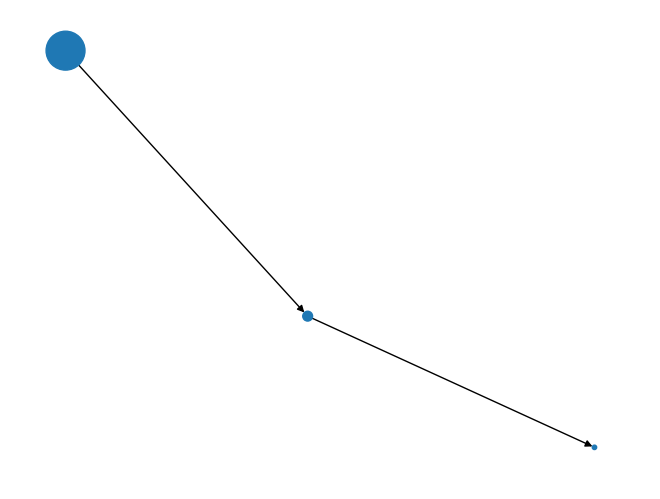

In [55]:
G = nx.DiGraph()

# Add input node
G.add_node(784) 
node_sizes = [784, 50, 10]
# Add hidden layer nodes 
G.add_node(model.fc1)
# Add output node
G.add_node(10)

# Add edges
G.add_edge(784, model.fc1)
G.add_edge(model.fc1, 10) 

nx.draw(G, node_size=node_sizes)

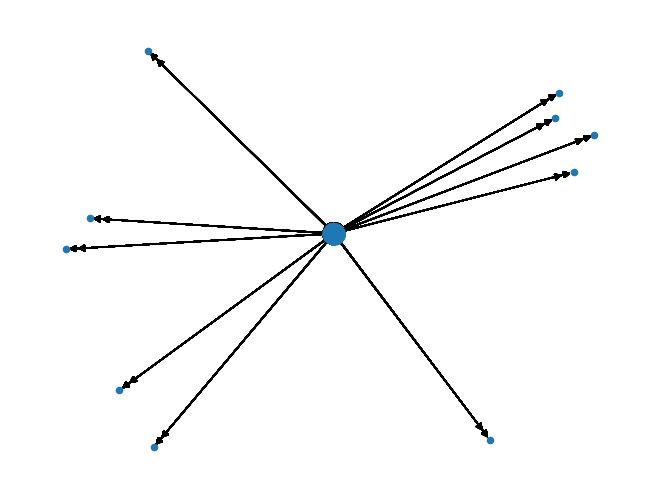

In [66]:
G = nx.DiGraph()

# Add nodes in layers
for i in range(784):
    G.add_node(i, layer="Input")

start = 784  
for i in range(50):
    G.add_node(i+start, layer="Hidden")

start += 50
for i in range(10): 
    G.add_node(i+start, layer="Output")

# # Add edges between layers
# for i in range(784):
#     G.add_edge(i, 784, layer="Input->Hidden")

# Add edges between Input and Hidden layers
for i in range(784):
    for j in range(784, 834):  # Nodes in the Hidden layer
        G.add_edge(i, j, layer="Input->Hidden")

# for i in range(50):
#     G.add_edge(i+784, 834, layer="Hidden->Output")

# Add edges between Hidden and Output layers
for i in range(784, 834):  # Nodes in the Hidden layer
    for j in range(834, 844):  # Nodes in the Output layer
        G.add_edge(i, j, layer="Hidden->Output")

pos = nx.spring_layout(G)

# Draw nodes
nx.draw(G, pos, node_size=20)
# Draw edges  
edges = nx.draw_networkx_edges(G, pos, edge_color="black")

plt.savefig('graph2.png')

<div style="line-height:0.48">
<h2 style="color:#BF66F2 ">  Create graph with netron and onnx </h2>
</div>

In [37]:
""" Visualize the model graph online. It automatically open your localhost to show the model network on the Netron site. """
torch.onnx.export(model, torch.randn(1,784), 'model.onnx')

netron.start('model.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Serving 'model.onnx' at http://localhost:8080


('localhost', 8080)

<div style="line-height:0.48">
<h2 style="color:#BF66F2 ">  Create graph with draw_graph from torchview </h2>
</div>

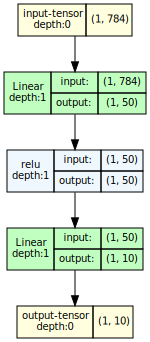

In [44]:
x = torch.randn(1,784) 
model_graph = draw_graph(model, input_size=x.size(), expand_nested=True)
model_graph.visual_graph

<div style="line-height:0.48">
<h2 style="color:#BF66F2 ">  Create graph with torchlens </h2>
</div>
It also creates and opens automatically the .gv file. <br>
N.B. <br>
Using torchlens a UserWarning is triggered to inform us that the .grad attribute of a Tensor that is not a leaf Tensor is being accessed. <br> 
Changes should be done in the library's code to use ".retain_grad()" in some cases. <br>
Hence the need to define a filter to avoid printing the annoying warning. <br>

In [49]:
# Define a custom warning filter
def custom_warning_filter(action, category, filename, lineno, message):
    # Check if the message matches the specific warning you want to ignore
    if "The .grad attribute of a Tensor" in str(message):
        return True  # Return True to ignore the warning
    else:
        return False  # Return False to handle other warnings normally

# Register the custom warning filter
warnings.filterwarnings("always", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="The .grad attribute of a Tensor")
# Suppress the warning message
warnings.showwarning = lambda *args, **kwargs: None 

# Reset the warning filter to its default behavior (if needed)
# warnings.resetwarnings()

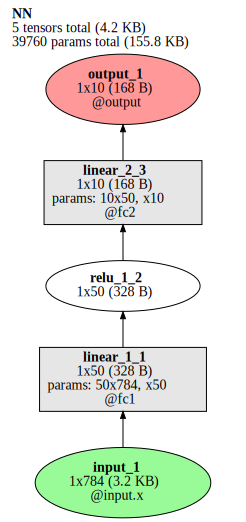

Log of NN forward pass:
	Random seed: 2871389742
	Time elapsed: 0.766s (0.755s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- no branching
		- no conditional (if-then) branching
		- 2 total modules
	Tensor info:
		- 5 total tensors (4.2 KB) computed in forward pass.
		- 5 tensors (4.2 KB) with saved activations.
	Parameters: 2 parameter operations (39760 params total; 155.8 KB)
	Module Hierarchy:
		fc1
		fc2
	Layers (all have saved activations):
		  (0) input_1 
		  (1) linear_1_1 
		  (2) relu_1_2 
		  (3) linear_2_3 
		  (4) output_1 


kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found


In [ ]:
""" Torchlens. """
model_history = tl.log_forward_pass(model, x, layers_to_save='all', vis_opt='unrolled')
print(model_history)

# Specify the desired location and filename
file_path = './graphs_nn/model_history.gv'

# Save the .gv file
graph = graphviz.Source(model_history)
graph.save(filename=file_path)